<a href="https://colab.research.google.com/github/khann160102/VietnamStreetFood/blob/main/VietnameseStreetFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as iter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session

# Data Import


Dataset: annotation-sheet.csv
*   [Dataset Github Link](https://github.com/khann160102/VietnamStreetFood/blob/main/annotation-sheet.csv)
*   [RAW Dataset Link](https://raw.githubusercontent.com/khann160102/VietnamStreetFood/main/annotation-sheet.csv)


1 - Data retrieve

In [ ]:
# Raw dataset link goes here
url = 'https://raw.githubusercontent.com/khann160102/VietnamStreetFood/main/annotation-sheet.csv'
df = pd.read_csv(url)

# Shuffle data (for fun, we'll shuffle the training set later anyway)
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,no,video_index,student_id,student_name,video_id,standardized_dish,dish_occurence,dish_imply,duration,start_time,...,standardized_sauce,sauce,venue,container,recipes,viewer_feeling,food_feeling,youtuber_feeling,location,foreigner
0,186,34,NaN,NaN,PUnKvRTvAjc,egg coffee,egg coffee,NaN,55,00:19,...,NaN,NaN,casual,glass,1,4,2,5,HN,1
1,1594,415,SE161261,Nguyễn Đoàn Hiếu Nguyên,U0xYFKNXap4,Egg coffee,NaN,Cà phê trứng,21,03:52,...,NaN,NaN,casual,glass,0,3,3,3,HN,1
2,1031,256,SE160513,Thái Võ Quốc Huy,xLKmhjy5Ai4,rice noodles with grilled meat,bun thit nuong,bún thịt nướng,257,00:07,...,NaN,fish sauce,casual,bowl,0,3,3,3,Nha Trang,1
3,2415,684,SE160144,Lê Tất Thành,kwwGvRUyIG8,Vanilla Bubble Waffle,Vanilla Bubble Waffle,Vanilla Bubble Waffle,55,09:00,...,NaN,NaN,street,hands_on,1,4,4,5,Ha Noi,1
4,3309,936,SE160195,Vũ An Ninh,Bh1kdtnkyQA,Vietnamese baked rolls,nem new,nem nướng,252,05:48,...,sweet peanut sauce,sweet peanut sauce,casual,plate,1,5,5,5,Da Lat,1


2 - Data Description

In [ ]:
print('Dataframe info:')
df.info()
print('\n\n')
print('Dataframe description: ')
df.describe().transpose()

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   no                              3757 non-null   int64 
 1   video_index                     3757 non-null   int64 
 2   student_id                      2884 non-null   object
 3   student_name                    2884 non-null   object
 4   video_id                        3757 non-null   object
 5   standardized_dish               3757 non-null   object
 6   dish_occurence                  3313 non-null   object
 7   dish_imply                      3159 non-null   object
 8   duration                        3757 non-null   int64 
 9   start_time                      3757 non-null   object
 10  end_time                        3757 non-null   object
 11  standardized_ingredient         3119 non-null   object
 12  no_ingredient                   

,count,mean,std,min,25%,50%,75%,max
no,3757.0,1879.000000,1084.696809,1.0,940.0,1879.0,2818.0,3757.0
video_index,3757.0,515.537131,315.761411,1.0,234.0,527.0,786.0,1068.0
duration,3757.0,110.310088,921.869713,0.0,26.0,60.0,118.0,55958.0
no_ingredient,3757.0,3.284802,2.806564,0.0,1.0,3.0,5.0,20.0
recipes,3757.0,0.274421,0.446281,0.0,0.0,0.0,1.0,1.0
viewer_feeling,3757.0,3.740484,0.925898,1.0,3.0,4.0,4.0,5.0
food_feeling,3757.0,3.412563,1.172153,1.0,2.0,4.0,4.0,5.0
youtuber_feeling,3757.0,4.195369,0.860721,1.0,4.0,4.0,5.0,5.0
foreigner,3757.0,0.933191,0.249724,0.0,1.0,1.0,1.0,1.0


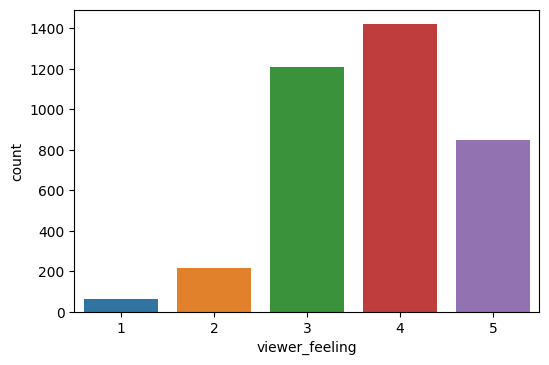

In [ ]:
plt.figure(dpi = 100)
ax = sns.countplot(data = df, x = 'viewer_feeling')
plt.show()

# Data Preprocessing

1.1 - One Hot Encoding (Columns = venue, container)

In [ ]:
label_df = pd.get_dummies(df[['venue', 'container']], prefix={'venue', 'container'}, dtype='int64')

1.2 - Data Scaling (Columns = duration, no_ingredient)

In [ ]:
df[["duration"]] = MinMaxScaler().fit_transform(df[["duration"]])
df[["no_ingredient"]] = MinMaxScaler().fit_transform(df[["no_ingredient"]])

# Model Building

1 - Define features (X) and data values (Y)

In [ ]:
X = df[['duration', 'no_ingredient', 'recipes']].join(label_df)
X.info()
Y = df['viewer_feeling']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration          3757 non-null   float64
 1   no_ingredient     3757 non-null   float64
 2   recipes           3757 non-null   int64  
 3   container_casual  3757 non-null   int64  
 4   container_fine    3757 non-null   int64  
 5   container_other   3757 non-null   int64  
 6   container_street  3757 non-null   int64  
 7   venue_bag         3757 non-null   int64  
 8   venue_bottle      3757 non-null   int64  
 9   venue_bowl        3757 non-null   int64  
 10  venue_box         3757 non-null   int64  
 11  venue_cup         3757 non-null   int64  
 12  venue_glass       3757 non-null   int64  
 13  venue_hands_on    3757 non-null   int64  
 14  venue_other       3757 non-null   int64  
 15  venue_plate       3757 non-null   int64  
 16  venue_pot         3757 non-null   int64  


2 - Build the model I guess

In [ ]:
# Sequential of course
clear_session()
model = Sequential()
model.add(Dense(16, input_shape = (X.shape[1],), activation='selu'))
model.add(Dense(32, activation='selu'))
model.add(Dense(16, activation='selu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                304       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1,478
Trainable params: 1,478
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', patience=100)
train = model.fit(X_train,
                  Y_train,
                  validation_data=(X_test, Y_test),
                  epochs = 500,
                  shuffle = True,
                  batch_size=128,
                  verbose=1,
                  callbacks=[early_stopping])

Epoch 1/500
24/24 [==============================] - 1s 12ms/step - loss: 1.5110 - accuracy: 0.3138 - val_loss: 1.3307 - val_accuracy: 0.3723
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.3175 - accuracy: 0.3714 - val_loss: 1.2618 - val_accuracy: 0.3963
Epoch 3/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2778 - accuracy: 0.4010 - val_loss: 1.2392 - val_accuracy: 0.4043
Epoch 4/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2636 - accuracy: 0.4060 - val_loss: 1.2268 - val_accuracy: 0.4388
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 1.2523 - accuracy: 0.4146 - val_loss: 1.2179 - val_accuracy: 0.4202
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2458 - accuracy: 0.4246 - val_loss: 1.2131 - val_accuracy: 0.4242
Epoch 7/500
24/24 [==============================] - 0s 4ms/step - loss: 1.2406 - accuracy: 0.4243 - val_loss: 1.2089 - val_accuracy: 0.4362
Epoch 8/500


# Model Evaluate

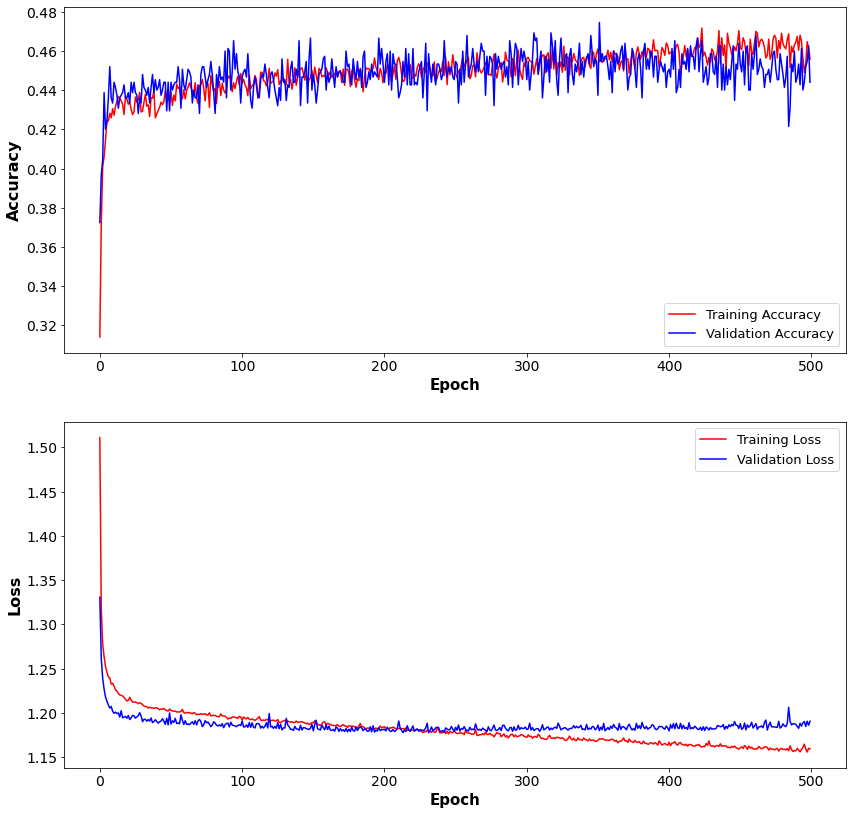

In [ ]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']

loss = train.history['loss']
val_loss = train.history['val_loss']

plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy', color='r')
plt.plot(val_accuracy, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Loss', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()